In [1]:
#To determine phase locking of all neurons in the PFC of an animal & report as population stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, butter, sosfilt
from scipy.stats import circvar, circmean

from set_input import set_input_params, path_to_input_file, load_input_params_base
set_input_params()
[cell_types, Data_folder, plot_folder_vlad, analysis_folder_vlad, plot_folder_andrea, analysis_folder_andrea, 
     parallel, days_8arm, days_prob, days_andrea, rats_vlad, rats_andrea, speed_threshold, sample_rate_whl, 
     sample_rate_data, tab20_colors]=load_input_params_base()

# print(days_andrea[-1]) #for just JC315

# print(rats_andrea) #for just JC315

# print(load_input_params_base())

# print(speed_threshold)

#base input parameters used:
    #sample_rate_data
    #speed_threshold
# print(sample_rate_whl)

In [2]:
def describe_clusters(des_filepath):
    file = open(des_filepath)
    des_raw = file.readlines()
    file.close()
    des = [i.strip('\n') for i in des_raw]
    pfc_clusters = [i + 2 for i, x in enumerate(des) if x == 'pp'] #selects all putative prefrontal pyramidal neurons (bilateral I think)
        #The value given in clu is described by des[value - 2] since cluster 1 is noise
    ca1_clusters = [i + 2 for i, x in enumerate(des) if x == 'p1'] ##selects all putative pyramidal neurons in the right dorsal hippocampus
    return pfc_clusters, ca1_clusters


In [3]:
'''Import spikes'''
#Import .res and .clu (code from Cell_map.ipynb)
def to_int_list(filename):
    '''
    Purpose: To import .res and .clu files
        .clu file is the cluster ID (putative neuron ID) for the corresponding .res file spikes
        .res file is the "frame" at sampling frequency 20kHz in which spikes occur
    Parameter: Full file path + ending of the .res or .clu file
    Return value (list of ints): Either the .res or .clu values
    '''
    file = open(filename)
    file_list = file.readlines()
    file.close()
    for i in range(len(file_list)):
        file_list[i] = int(file_list[i].strip('\n'))
    return file_list

In [4]:
def import_speed(speed_filepath):
    file = open(speed_filepath) #Different than to_int_list() above because these are float values
    speed = file.readlines()
    file.close()
    for i in range(len(speed)):
        speed[i] = float(speed[i].strip('\n'))
    return speed

def filter_for_speed(speed, cell_number, clu, res, speed_threshold = speed_threshold):
    '''
    Purpose: To determine which spikes occured when the animal was in motion = abs(speed) >= speed_threshold cm/s
        Will also return 'NaN' for cells which have an average firing rate less than 0.25 spikes/second, as with Nardin et al., 2023
            (see "Dataset details" in the methods section)
    Parameters: 
        speed_filepath (str): full filepath of the .speed file for a specific training session
        cell_number (int): identity of the putative neuron, as with in the .clu file
        clu (list): imported clu file, with first (noise) cluster removed
        res (list): imported res file
    Return value (list): recording "frames" (at 20 kHz) in which the animal was in motion and the specified cell spiked
    '''
    
    spike_index = [i for i, x in enumerate(clu) if x == cell_number] #since clu and res have corresponding indices
    all_spikes = [res[i] for i in spike_index] #in frame number of the spike recording, in 20kHz
    spike_frame = [i for i in all_spikes if abs(speed[i // 512]) >= speed_threshold] 
        #if the speed during a spike is 5cm/s or above, the spike is kept

    # print('total time:', (1/20_000 * res[-1]), 'sec')
    # print('avg firing rate:', len(all_spikes) / (1/20_000 * res[-1]), 'sp/sec')
    if len(all_spikes) / (1/sample_rate_data * res[-1]) < 0.25:
        # print('cell ' + str(cell_number) + ' has a sub-threshold avg firing rate')
        return 'NaN'
        
    return spike_frame

In [5]:
def get_significant_theta(amplitude_envlope):
    significance_threshold = np.mean(amplitude_envelope) + np.std(amplitude_envelope)
    significant_theta = []
    for i in range(len(amplitude_envelope) // 1000):
        if np.mean(amplitude_envelope[i * 1000 : (i + 1) * 1000]) >= significance_threshold:
            significant_theta.append(True)
        else:
            significant_theta.append(False)
    return significant_theta

def filter_for_theta_significance(significant_theta, cell_number, clu, res):
       
    spike_index = [i for i, x in enumerate(clu) if x == cell_number] #since clu and res have corresponding indices
    all_spikes = [res[i] for i in spike_index] #in frame number of the spike recording, in 20kHz
    if max(all_spikes) // 4000 >= len(significant_theta):
        print('indexing issue with' + str(cell_number))
        # raise Error('list index error with ' + str(cell_number))
        return 'NaN'
    spike_frame = [i for i in all_spikes if significant_theta[i // 4000]]
        #spike frames are in 20kHz, significant theta is in 5kHz/1000 = 5 Hz. So the conversion would be // 4000
    if len(all_spikes) / (1/sample_rate_data * res[-1]) < 0.25:
        return 'NaN'
    return spike_frame

In [16]:
def unfiltered_spike_frames(cell_number, clu, res):
    spike_index = [i for i, x in enumerate(clu) if x == cell_number] #since clu and res have corresponding indices
    all_spikes = [res[i] for i in spike_index] #in frame number of the spike recording, in 20kHz
    if len(all_spikes) / (1/sample_rate_data * res[-1]) < 0.25:
        return 'NaN'
    return all_spikes
    

In [30]:
'''Import eegh, determine spike phases'''
def calculate_eeg_phase(eegh_filepath, tetrode_number, eeg_fs = 5000):
    '''
    Purpose: Bandpass (3rd-order Butterworth) filter the eegh data for the theta range (5-12 Hz),
        extract phase using the Hilbert transform, and return the theta phase during each spike in spike_frame
    Parameter(s): 
        eegh_filepath (str):
        tetrode_number (int): 
        spike_frame (list of ints): the output of filter_for_speed()
    Return value (list): spike_phase, a list of equal length to spike_frame
    
    -Assumes that there are always 32 channels in the eegh recording
    '''
    eeg = np.fromfile(eegh_filepath, dtype = np.uint16)
    one_channel = eeg[int(tetrode_number*len(eeg)/32) : int((tetrode_number+1)*len(eeg)/32)]
    
    
    #calculate inst_phase for the entire eegh recording
    sos = butter(3, [5, 28], btype = 'bandpass', output = 'sos', analog = False, fs = eeg_fs) #Filter range could be [5, 12] or [5, 28]
    filtered = sosfilt(sos, one_channel)
    
    # t = np.arange(len(subsample)) / fs  #Creating time axis if you want to plot signal vs. time
    
    analytic_signal = hilbert(filtered) #Where filtered is a ~1s portion of the theta band-pass filtered EEG
    amplitude_envelope = np.abs(analytic_signal)
    inst_phase = np.unwrap(np.angle(analytic_signal))
    # inst_freq = (np.diff(inst_phase) / 
    #              (2.0 * np.pi) * eeg_fs)
    return inst_phase, amplitude_envelope


def calculate_spike_phase(inst_phase, spike_frame, eeg_fs = 5000, sample_rate_data = sample_rate_data):
    conversion = sample_rate_data / eeg_fs
    # spike_phase = [inst_phase[round(i / conversion)] for i in spike_frame] #inst theta phase of the eeg during each spike
    if max(spike_frame) // conversion > len(inst_phase):
        print('len inst phase: ' + str(len(inst_phase)))
        print('max spike_frame: ' + str(max(spike_frame)))
        print('eeg fs: ' + str(eeg_fs) + ' sample rate data ' + str(sample_rate_data) + ' conversion: ' + str(conversion))
    spike_phase = [inst_phase[int(i // conversion)] for i in spike_frame]
    # spike_time = [i / 20_000 for i in spike_frame] #time [s] of each spike, only necessary to plot polar w/ radius = time
    return spike_phase

In [7]:
def stats(spike_phase):
    '''
    From J.H. Zar Biostatistical Analysis 5th Ed., 2010, p. 625

    Return values:
    a_bar (int, [rads]): preferred firing phase (resultant vector direction)
    r: mean resultant vector length (MVL) -- ranges from 0-1
    p-val: an approximation to the probability of Rayleigh's R (Zar, 2010)
    '''
    n = len(spike_phase) #sample size
    X = (1/n) * sum([np.cos(i) for i in spike_phase]) #x-coord of the resultant vector
    Y = (1/n) * sum([np.sin(i) for i in spike_phase]) #y-coord of the resultant vector
    r = np.sqrt(X**2 + Y**2) #Mean resultant vector length
    R = n * r #R = Rayleigh's R
    z = n * r**2 #z = Rayleigh's z
    a_bar = np.arctan2(Y, X) #Mean direction, in rad
        #Make this so that it can only be positive, though arctan only returns values between -pi and pi I think
    p_val = np.exp((1 + 4*n + 4*(n**2 - R**2))**0.5 - (1 + 2*n))
    return a_bar, r, p_val

#Could also convert mean_direction to degrees

    # #From https://www.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics
    # mean_direction = circmean(spike_phase) # in rads
    # n = len(spike_phase)
    # r = 1 - circvar(spike_phase) #The resultant vector length
    
    # R = n*r #Rayleigh's R
    # z = R**2 / n #Rayleigh's z

    # # compute p value using approxation in Zar, p. 617
    # # pval = exp(sqrt(1+4*n+4*(n^2-R^2))-(1+2*n));
    # # math.exp(math.sqrt(1 + 4 * n + 4 * (n**2 - R**2)) - (1 + 2 * n))
    # #
    # pval = np.exp(np.sqrt(1 + 4 * n + 4 * (n**2 - R**2)) - (1 + 2 * n))
    # return mean_direction, r, R, z, pval

In [14]:
def get_selective_cells(cell_list, speed_filter = False, theta_filter = False):
    '''
    *Only either speed_filter or theta_filter can be applied, or neither. Not both.
    '''
    cells = []
    mean_directions = []
    pvals = []
    resultant_vector_lengths = []
    for cell_number in cell_list:
        if speed_filter:
            spike_frame = filter_for_speed(speed, cell_number, clu, res)
        elif theta_filter:
            spike_frame = filter_for_theta_significance(significant_theta, cell_number, clu, res)
        else:
            spike_frame = unfiltered_spike_frames(cell_number, clu, res)

        
        if spike_frame == 'NaN':
            # cells.append('low')
            # mean_directions.append('NaN')
            # pvals.append('NaN')
            pass
        else:
            spike_phase = calculate_spike_phase(inst_phase, spike_frame)
            mean_direction, MVL, p_val = stats(spike_phase)
            cells.append(cell_number)
            mean_directions.append(mean_direction)
            resultant_vector_lengths.append(MVL)
            pvals.append(p_val)
    selective_indices = [i for i, x in enumerate(pvals) if x < 0.05]
    for i in selective_indices:
        print(f'Cell {cells[i]} is selective for {mean_directions[i] * 180 / np.pi:.0f}° with MVL {resultant_vector_lengths[i]:.3f}')
    print(f'Proportion of cells that are selective: {len(selective_indices) / len(cells):.3f}  ')
    return cells, resultant_vector_lengths, mean_directions, pvals

In [31]:
tetrode_number = 26 #Can check in google sheets which tetrodes work based on training day, usually 17-32 is fine
    #For JC315, tetrode 17 is in the HPC pyrimidale every day
    #JC283 varies a lot more and doesn't always have pyramidale
        #20230930 [25,27, 30, 21] are pyramidale; 
        #20231001 and 02 [26, 30] are oriens/sup. pyramidale; 
        #20231003 [17, 19, 25] in pyramidale


#For training 1 in JC315 20240407
clu_res_filepath = 'JC315-20240407/JC315-20240407_training1'
eegh_filepath = 'JC315-eegh/20240407/JC315-20240407_02.eegh'
speed_filepath = 'eight_arm_fig_data_andrea/analysis/JC315-20240407/JC315_20240407_training1.speed'
des_filepath = 'JC315-20240407/JC315-20240407.des'
des_full_filepath = 'JC315-20240407/JC315-20240407.des_full'

# #For training 1 in JC315 20240408
# clu_res_filepath = 'JC315-20240408/JC315-20240408_training1'
# eegh_filepath = 'JC315-eegh/20240408/JC315-20240408_02.eegh'
# speed_filepath = 'eight_arm_fig_data_andrea/analysis/JC315-20240408/JC315_20240408_training1.speed'
# des_filepath = 'JC315-20240408/JC315-20240408.des'
# des_full_filepath = 'JC315-20240408/JC315-20240408.des_full'

clu = to_int_list(clu_res_filepath + '.clu')[1:]#Removing the first (noise) cluster
res = to_int_list(clu_res_filepath + '.res')
pfc_clusters, ca1_clusters = describe_clusters(des_filepath)


file = open(des_full_filepath)
des_raw = file.readlines()
file.close()
des_full = [i.strip('\n') for i in des_raw]
pfc_right_clusters = [i + 2 for i, x in enumerate(des_full) if x == 'pfc_right']


speed = import_speed(speed_filepath)
inst_phase, amplitude_envelope = calculate_eeg_phase(eegh_filepath, tetrode_number)
significant_theta = get_significant_theta(amplitude_envelope)





print('Right PFC cells')
pfc_cells, pfc_resultant_vector_lengths, pfc_mean_directions, pfc_pvals = get_selective_cells(
    pfc_right_clusters, speed_filter = False, theta_filter = False)

print('\nHPC cells')
hpc_cells, hpc_resultant_vector_lengths, hpc_mean_directions, hpc_pvals = get_selective_cells(
    ca1_clusters, speed_filter = False, theta_filter = False)


# print(cells)
# print(pvals)

Right PFC cells
len inst phase: 9384960
max spike_frame: 37540156
eeg fs: 5000 sample rate data 20000 conversion: 4.0


IndexError: index 9385039 is out of bounds for axis 0 with size 9384960

In [32]:
37540156 / 4

9385039.0

In [42]:
# print(f'Len res: {len(res)} in sampling rate {sample_rate_data} \nLen inst_phase: {len(inst_phase)} and len amp env: {
#     len(amplitude_envelope)} in sampling rate 5000 for eegh \nSo conversion: {sample_rate_data / 5_000} and max spike frame or max res, {
#     max(res) /  (sample_rate_data / 5_000)} should be lower than {len(inst_phase)}') 

# print(f'Max res is {max(res)} and len res is {len(res)} ')

print(f'Max res {max(res)} divided by 4 {max(res) / 40} should be a tiny bit lower than len eegh which is len inst_phase {len(inst_phase)} ')

# conversion = sample_rate_data / eeg_fs
#     # spike_phase = [inst_phase[round(i / conversion)] for i in spike_frame] #inst theta phase of the eeg during each spike
#     if max(spike_frame) // conversion > len(inst_phase):
#         print('len inst phase: ' + str(len(inst_phase)))
#         print('max spike_frame: ' + str(max(spike_frame)))
#         print('eeg fs: ' + str(eeg_fs) + ' sample rate data ' + str(sample_rate_data) + ' conversion: ' + str(conversion))
#     spike_phase = [inst_phase[int(i // conversion)] for i in spike_frame]
#     # spike_time = [i / 20_000 for i in spike_frame] #time [s] of each spike, only necessary to plot polar w/ radius = time
#     return spike_phase

Max res 37540215 divided by 4 938505.375 should be a tiny bit lower than len eegh which is len inst_phase 9384960 


In [23]:
# print(len(pfc_cells))

# print(pfc_mean_directions[0])
# print(pfc_resultant_vector_lengths)

# print(pfc_cells)

# [pfc_resultant_vector_lengths[i] for i, x in enumerate(pfc_cells) if x == 43]

print([pfc_resultant_vector_lengths[i] for i, x in enumerate(pfc_cells) if x in [25, 55, 82, 95]])
print([pfc_pvals[i] for i, x in enumerate(pfc_cells) if x in [25, 55, 82, 95]])


print([hpc_resultant_vector_lengths[i] for i, x in enumerate(hpc_cells) if x in [100, 102, 119, 136, 147, 156, 160, 162]])

[0.060180819218137144, 0.021394122399299997, 0.04105735266261026, 0.04515471725254283]
[0.006061289852374634, 0.023245357963349925, 0.012498400948372351, 0.006475097001799707]
[0.12403302780988464, 0.015770786413553606, 0.01288962727943565, 0.07183688819266888, 0.23285272994021605, 0.07043055451046241, 0.05259171306233049, 0.03650046571482509]


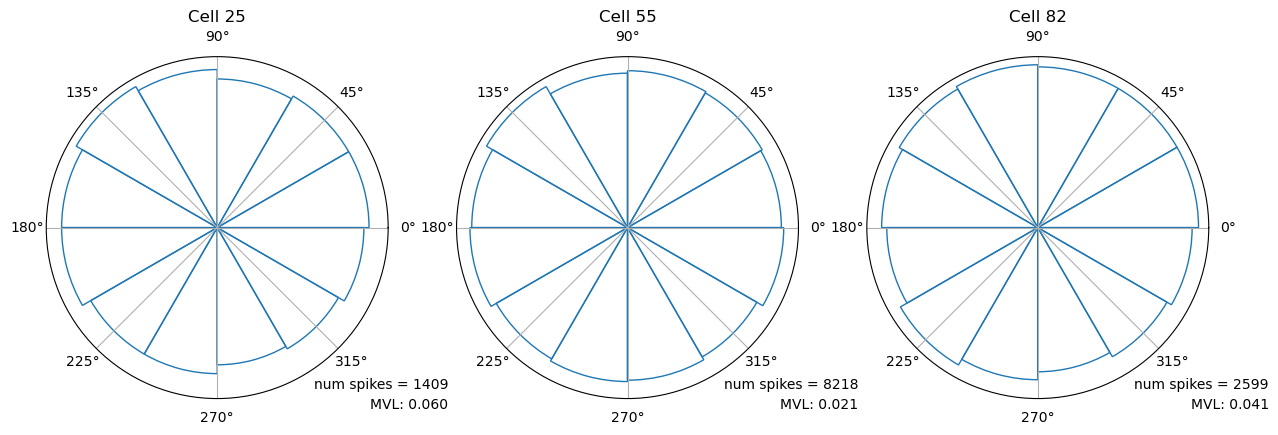

In [74]:
'''Plot specific cells'''
#as a circular histogram (rose diagram)
#Modified from circular_hist() in https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python
    #Also, "A true-area rose diagram can be obtained by plotting the square roots of frequencies as radii" 
        #(J.H. Zar, Biostatistical Analysis, p.608)

cell_numbers = [25, 55, 82]
fig, ax = plt.subplots(1, 3, subplot_kw = {'projection': 'polar'}, figsize = (15, 45))
num_bins = 12 #Using 12 bins, as with figure 3A in Nardin et al., 2023
bins = np.linspace(-np.pi, np.pi, num_bins + 1) #Bin the angles


for plot_num, cell_number in enumerate(cell_numbers): 
    spike_frame = filter_for_speed(speed, cell_number, clu, res)
    spike_phase = calculate_spike_phase(inst_phase, spike_frame)
    mean_direction, MVL, p_val = stats(spike_phase)
    
    wrapped_angles = [(i + np.pi) % (2*np.pi) - np.pi for i in spike_phase]
    
    n = []
    for i in range(num_bins):
        start_angle = bins[i]
        end_angle = bins[i + 1]
        count = len([i for i in wrapped_angles if start_angle <= i < end_angle])
        n.append(count)
    
    radius = [(i / sum(n))**0.5 for i in n]
    ax[plot_num].set_yticks([])
    ax[plot_num].bar(bins[:-1], radius, zorder = 1, align = 'edge',
           edgecolor = 'C0', fill = False, linewidth = 1, width = (2*np.pi) / num_bins)
    ax[plot_num].set_title(f'Cell {cell_number}')
    ax[plot_num].annotate('num spikes = ' + str(sum(n)), xy = (1, 0), xycoords = 'axes fraction',
               xytext = (60, 10), textcoords = 'offset pixels', horizontalalignment = 'right')
    ax[plot_num].annotate(f'MVL: {MVL:.3f}', xy = (1, 0), xycoords = 'axes fraction',
               xytext = (60, -10), textcoords = 'offset pixels', horizontalalignment = 'right')

#Next I want to add an arrow in the direction of a_bar

In [ ]:
spike_frame = filter_for_speed(speed, cell_number, clu, res)


fig, axs = plt.subplots(1, 3, figsize = (16, 5))
axs[0].remove()
axs[0] = fig.add_subplot(1, 3, 1, projection = 'polar')
axs[0].scatter(spike_phase, spike_time, s = 5, alpha = 0.6)
# axs[0].set_rticks([])
axs[0].set_rticks([500, 1000, 1500, 2000]) #Set radial ticks (in seconds)
axs[0].grid(True)
axs[0].set_title('Spike phase vs. time')

# axs[1].plot(np.cos(np.linspace(0, 2*np.pi, 500)),
#            np.sin(np.linspace(0, 2*np.pi, 500)),
#            c='k')
#But I want to jitter this somehow
axs[1].axis('equal')
axs[1].axis('off')
axs[1].scatter(np.cos(spike_phase), np.sin(spike_phase), s=8, alpha = 0.6) #c='k'
axs[1].set_title('Circular variance') #Can also add the value in here


#Modified from circular_hist() in https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python
num_bins = 12 #Using 12 bins, as with figure 3A in Nardin et al., 2023

wrapped_angles = [(i + np.pi) % (2*np.pi) - np.pi for i in spike_phase]
#can now make a cartesian hist with plt.hist(wrapped_angles, bins = 12)

bins = np.linspace(-np.pi, np.pi, num_bins + 1) #Bin the angles

n = []
for i in range(num_bins):
    start_angle = bins[i]
    end_angle = bins[i + 1]
    count = len([i for i in wrapped_angles if start_angle <= i < end_angle])
    n.append(count)

#Can either plot so that the amt in each bin corresponds to the area OR the radius of each pie slice, I chose area.
area = [i / len(wrapped_angles) for i in n]
radius = [(i / np.pi)**0.5 for i in area]

#"A true-area rose diagram can be obtained by plotting the square roots of frequencies as radii" (J.H. Zar, Biostatistical Analysis, p.608)
radius2 = [(i / sum(n))**0.5 for i in n] #But it seems like this does the same as above

print(sum(n))

#Plot
axs[2].remove()
axs[2] = fig.add_subplot(1, 3, 3, projection = 'polar')
axs[2].set_yticks([])
axs[2].bar(bins[:-1], radius2, zorder=1,  align='edge',
                     edgecolor='C0', fill=False, linewidth=1, width = (2 * np.pi) / num_bins) #width=widths

axs[2].set_title('Circular histogram')